# ФОрмулы и вводная часть

In [1]:
import os
import scipy.io
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
import h5py

class DigitStructFile:
    """
    MATLAB 7.3 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 20:52:58 2011 HDF5 schema 1.00 
    DigitStructFile - это просто оболочка для данных h5py. Это в основном ссылки
        inf: входной файл h5 matlab
        digitStructName Ссылка h5 на все имена файлов
        digitStructBbox Ссылка h5 на все структурированные данные
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

        
    def bboxHelper(self, attr):
        """
        bboxHelper handles the coding difference, 
        when there is exactly one bbox or an array of bbox.         
        """
        if (len(attr) > 1):
            attr = [self.inf[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr
    
    def bboxHelper_(self, attr):
        """
        bboxHelper обрабатывает разницу, 
        когда есть ровно один bbox или массив bbox-сов.
        """
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr
   
    def getName(self,n):
        # getName returns the 'name' string for the n(th) digitStruct. 
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
    
    def getBbox(self, n):
        # getBbox returns a dict of data for the n(th) bbox.
        bb = self.digitStructBbox[n].item()
        return dict(
            height = self.bboxHelper(self.inf[bb]["height"]),
            label = self.bboxHelper(self.inf[bb]["label"]),
            left = self.bboxHelper(self.inf[bb]["left"]),
            top = self.bboxHelper(self.inf[bb]["top"]),
            width = self.bboxHelper(self.inf[bb]["width"])
        )

    def getDigitStructure(self, n):
        # getDigitStructure returns the digitStruct from the input file.     
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        # getAllDigitStructure returns all the digitStruct from the input file.     
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        """
        Return a restructured version of the dataset (one structure by boxed digit).
        Return a list of such dicts : 
            'filename' : filename of the samples
            'boxes' : list of such dicts (one by digit) :
            'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
            'left', 'top' : position of bounding box
            'width', 'height' : dimension of bounding box
        Note: We may turn this to a generator, if memory issues arise.
        """
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                # In metadata zero replaced to ten
                figure['label']  = 0 if pictDat[i]['label'][j] == 10 else pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [3]:
# Load data set
train_folders = './data/train'
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [4]:
# Load data set
test_folders = './data/test'
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf_test = DigitStructFile(fin)
test_data = dsf_test.getAllDigitStructure_ByDigit()

In [5]:
# Load data set
extra_folders = './data/extra'
fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

## Меняем размер исходного изображения на 32 х 32.  
В центре полученного изображения номер дома.  
В скрипте приложенном к набору данных «see_bboxes.mat» задана область (bbox) для каждой цифры номера дома.  
* ```aa = max(digitStruct(i).bbox(j).top+1,1);``` - Начало цифры на изображении (сверху).  
* ```bb = min(digitStruct(i).bbox(j).top+digitStruct(i).bbox(j).height, height);``` - Начало цифры на изображении (сверху) + высота цифры.  
* ```cc = max(digitStruct(i).bbox(j).left+1,1);``` - Начало цифры на изображении (слева)  
* ```dd = min(digitStruct(i).bbox(j).left+digitStruct(i).bbox(j).width, width);``` - Начало цифры на изображении (слева) + ширина цифры.

Вычисляем область (bbox) для всего номера.  
Прибавляем к этой области отступ, захватывая часть изображения не с номером дома. 
Рассмотрим полученное изображеник как массив значений.  
Нормируем полученные значения как указанно в источнике [источнике](https://github.com/hangyao/street_view_house_numbers/blob/master/3_preprocess_multi.ipynb).

### Проделаем описанную последовательность для первого изображение из тренировочного набора.

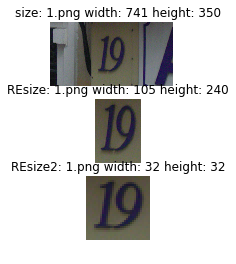

In [87]:
# Visualisation image

f, ax = plt.subplots(nrows=3, ncols=1)
ax[0].axis('off'); ax[0].set_title(str_, loc='center')
ax[1].axis('off') 
ax[2].axis('off'); ax[2].set_title(str_, loc='center')
fullname = os.path.join(train_folders, train_data[0]['filename'])
with Image.open(fullname) as im:
    
    str_ = f"size: {train_data[0]['filename']} width: {im.size[0]} height: {im.size[1]}"
    ax[0].set_title(str_, loc='center')
    ax[0].imshow(np.asanyarray(im))
    
    # resize
    # arrays with a coordinate digit bboxes
    len_boxes = len(train_data[0]['boxes'])
    top = np.ndarray([len_boxes], dtype='float32')
    left = np.ndarray([len_boxes], dtype='float32')
    height = np.ndarray([len_boxes], dtype='float32')
    width = np.ndarray([len_boxes], dtype='float32')
    
    for position in np.arange(len_boxes):
        
        top[position] = train_data[0]['boxes'][position]['top']
        height[position] = train_data[0]['boxes'][position]['height']
        left[position] = train_data[0]['boxes'][position]['left']                
        width[position] = train_data[0]['boxes'][position]['width']
        
    # Calculate slices for bboxes all number
    im_top = int(np.amin(top - 0.1 * height))
    # начало числа + константный отступ, что бы номер был более "в центер" изображения
    im_height = int(np.amax(top + height + 0.1 * height))
    im_left = int(np.amin(left - 0.1 * width))
    im_width = int(np.amax(left + width + 0.1 * width))
    
    
    str_ = (f"REsize: {train_data[0]['filename']} "
            f"width: {int(np.amax(width + 0.1 * width))} "
            f"height: {int(np.amax(height + 0.1 * height))}")    
    ax[1].set_title(str_, loc='center')
    ax[1].imshow(np.asanyarray(im)[int(im_top): int(im_height), 
                             int(im_left): int(im_width), :])
    
    # Cut 32 x 32
    str_ = (f"REsize2: {train_data[0]['filename']} "
            f"width: 32 height: 32") 
    ax[2].set_title(str_, loc='center')
    im = im.crop((im_left, im_top, im_width, im_height)).resize([32,32], Image.ANTIALIAS)
    ax[2].imshow(im)

In [88]:
# Normalize
im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
mean = np.mean(im, dtype='float32')
std = np.std(im, dtype='float32', ddof=1)
if std < 1e-4: std = 1.
im = (im - mean) / std
print(im[:,:,:])

[[[-0.07123722]
  [-0.12508228]
  [-0.09718888]
  ...
  [ 0.04250604]
  [ 0.06527073]
  [ 0.12900174]]

 [[ 0.02169997]
  [ 0.0092771 ]
  [-0.05569914]
  ...
  [ 0.11638471]
  [ 0.19071926]
  [ 0.18935582]]

 [[ 0.0526537 ]
  [ 0.05557896]
  [-0.02838405]
  ...
  [ 0.22349653]
  [ 0.17075319]
  [ 0.24391848]]

 ...

 [[ 1.27920333]
  [ 1.22665416]
  [ 1.26105658]
  ...
  [ 1.19751553]
  [ 1.19862147]
  [ 1.16031448]]

 [[ 1.27757396]
  [ 1.27022493]
  [ 1.2606007 ]
  ...
  [ 1.26378767]
  [ 1.15095196]
  [ 1.16239551]]

 [[ 1.26768802]
  [ 1.29363968]
  [ 1.35717652]
  ...
  [ 1.25624446]
  [ 1.23400319]
  [ 1.20505873]]]


  
### Проделаем описанную последовательность для все изображение из наборов данных.
  

In [7]:
# Get size source image
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    with Image.open(fullname) as im:
        train_imsize[i] = im.size
print(f"In train data set")
print(f"max width: {np.amax(train_imsize[:,0])}, max height: {np.amax(train_imsize[:,1])}")
print(f"mix width: {np.amin(train_imsize[:,0])}, mix height: {np.amin(train_imsize[:,1])}")

In train data set
max width: 876.0, max height: 501.0
mix width: 25.0, mix height: 12.0


In [8]:
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print(f"In test data set")
print(f"max width: {np.amax(test_imsize[:,0])}, max height: {np.amax(test_imsize[:,1])}")
print(f"mix width: {np.amin(test_imsize[:,0])}, mix height: {np.amin(test_imsize[:,1])}")

In test data set
max width: 1083.0, max height: 516.0
mix width: 31.0, mix height: 13.0


In [9]:
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]

print(f"In extra data set")
print(f"max width: {np.amax(extra_imsize[:,0])}, max height: {np.amax(extra_imsize[:,1])}")
print(f"mix width: {np.amin(extra_imsize[:,0])}, mix height: {np.amin(extra_imsize[:,1])}")

In extra data set
max width: 668.0, max height: 415.0
mix width: 22.0, mix height: 13.0


Warning 29930.png image has more than 5 digits.
(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


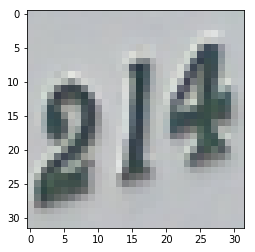

In [92]:
def generate_dataset(data, folder):
    dataset = np.ndarray([len(data), 32, 32, 1], dtype='float32')  # bbox with single digit
    labels = np.ones([len(data), 6], dtype=int) * np.nan  # ground truth for the digit on image
    
    for current_image in np.arange(len(data)):
        fullname = os.path.join(folder, data[current_image]['filename'])
        with Image.open(fullname) as im:
            
            boxes = data[current_image]['boxes']  # boxes on image with digit
            count_digit_on_image = len(boxes)  # calculate count digit on image
            
            labels[current_image, 0] = count_digit_on_image  # write digit count to labels array 
            
            # arrays with a coordinate digit bboxes
            top = np.ndarray([count_digit_on_image], dtype='float32')
            left = np.ndarray([count_digit_on_image], dtype='float32')
            height = np.ndarray([count_digit_on_image], dtype='float32')
            width = np.ndarray([count_digit_on_image], dtype='float32')
            
            # the position of the digits in a number
            for position in np.arange(count_digit_on_image):  
                if position < 5:
                    labels[current_image, position + 1] = boxes[position]['label']
                    # In metadata zero replaced to ten
                    if boxes[position]['label'] == 10: 
                        print(f"Warning {data[current_image]['filename']} labele == 10.")
                        labels[current_image, position + 1] = 0
                else:
                    print(f"Warning {data[current_image]['filename']} image has more than 5 digits.")
                    pass
                
                top[position] = boxes[position]['top']
                height[position] = boxes[position]['height']
                left[position] = boxes[position]['left']                
                width[position] = boxes[position]['width']
            
            # Calculate slices for bboxes all number
            im_top = np.amin(top - 0.1 * height)  
            # начало числа + константный отступ, что бы номер был более "в центер" изображения
            im_height = np.amax(top + height + 0.1 * height)
            im_left = np.amin(left - 0.1 * width)
            im_width = np.amax(left + width + 0.1 * width)
            
            # Normalize
            im = im.crop((im_left, im_top, im_width, im_height)).resize([32,32], Image.ANTIALIAS)            
            im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
            mean = np.mean(im, dtype='float32')
            std = np.std(im, dtype='float32', ddof=1)
            if std < 1e-4: std = 1.
            im = (im - mean) / std
            dataset[current_image,:,:,:] = im[:,:,:]
                          
    return dataset, labels
                          
train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

In [93]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [94]:
print(train_dataset.shape, train_labels.shape)

(33401, 32, 32, 1) (33401, 6)


In [95]:
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

print(train_dataset_t.shape, train_labels_t.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


In [96]:
pickle_file = 'SVHN_multi.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Unable to save data to SVHN_multi.pickle : name 'pickle' is not defined


NameError: name 'pickle' is not defined